In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pyaudio
import time
import threading
from collections import Counter
import json

In [122]:
def plot_spectrogram(DB, sr, title):
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(DB, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

def plot_marked_spectogram(y_coords, x_coords, y, title):
    plt.figure(figsize=(12, 6))  # Increased figure size
    plt.imshow(y, cmap='gray', interpolation='none', aspect='auto')  # Set aspect ratio to 'auto'
    plt.scatter(x_coords, y_coords, color='red', marker='o', s=10)
    plt.title(title)
    plt.xlabel('X Coordinates')
    plt.ylabel('Y Coordinates')
    plt.gca().invert_yaxis()
    plt.show()

def plot_hist(counter, title):
    labels, values = zip(*counter.items())
    plt.figure(figsize=(10, 6))
    plt.bar(labels, values, color='blue')
    plt.xlabel('Items')
    plt.ylabel('Count')
    plt.title(title)
    plt.show()

In [123]:
def find_local_maxima(matrix, neighborhood_size):
    if neighborhood_size % 2 == 0:
        raise ValueError("Neighborhood size must be odd.")
    
    pad_size = neighborhood_size // 2
    y_cords = []
    x_cords = []

    for i in range(pad_size, matrix.shape[0] - pad_size):
        for j in range(pad_size, matrix.shape[1] - pad_size):
            neighborhood = matrix[i - pad_size:i + pad_size + 1, j - pad_size:j + pad_size + 1]
            center_value = matrix[i, j]
            
            temp = neighborhood[neighborhood != center_value]
            if len(temp) != 0 and center_value > np.max(temp):
                y_cords.append(i)
                x_cords.append(j)
    
    return y_cords, x_cords

def find_maxims(matrix, chunk_size):
    y_cords = list(np.argmax(matrix, axis=0))
    x_cords = list(range(len(y_cords)))
    y_rez, x_rez = [], []
    for i in range(0, len(y_cords), chunk_size):
        chunk = y_cords[i:i + chunk_size]
        max_index = np.argmax(chunk)
        global_max_index = i + max_index
        y_rez.append(int(y_cords[global_max_index]))
        x_rez.append(int(x_cords[global_max_index]))

    return y_rez, x_rez

def find_local_maxima_heuristic(matrix, population_size, num_iterations, neighborhood_size):
    m, n = matrix.shape
    y_coords = np.random.uniform(neighborhood_size, m, population_size).astype(int)
    x_coords = np.random.uniform(neighborhood_size, n, population_size).astype(int)
    y_rez = []
    x_rez = []
    matrix = np.pad(matrix, pad_width=neighborhood_size, mode='constant', constant_values=-np.inf)
    for y, x in zip(y_coords, x_coords):
        for _ in range(num_iterations):
            okolina = matrix[y-neighborhood_size:y+neighborhood_size + 1 , x-neighborhood_size:x+neighborhood_size + 1]
            if okolina.size == 0:
                break
            max_index = np.argmax(okolina)
            dim = (2*neighborhood_size + 1)
            if(max_index // dim == neighborhood_size and max_index % dim == neighborhood_size):
                break
            y = y + max_index // dim - neighborhood_size
            x = x + max_index % dim - neighborhood_size

        if(y - neighborhood_size not in y_rez or x - neighborhood_size not in x_rez):
            y_rez.append(int(y - neighborhood_size))
            x_rez.append(int(x - neighborhood_size))
    
    return y_rez, x_rez

In [124]:
def evaluate_similarity(x_original, y_original, x_test, y_test, tolerance_y, tolerance_x):
    hist = []
    for i in range(len(x_original)):
        for j in range(len(x_test)):
            if(abs(y_original[i] - y_test[j]) < tolerance_y):
                hist.append(x_original[i] - x_test[j])

    hist = Counter(hist)
    print(hist.most_common(3))
    return hist

In [125]:
def test_fingerprinting(original, positive_test, negative_test, f, args):
    y_original, x_original = f(original, *args)
    plot_marked_spectogram(y_original, x_original, original, "Originalni zvijezde")
    y_test_positive, x_test_positive = f(positive_test, *args)
    plot_marked_spectogram(y_test_positive, x_test_positive, positive_test, "Odgovarajuci testni zvijezde")
    y_test_negative, x_test_negative = f(negative_test, *args)
    plot_marked_spectogram(y_test_negative, x_test_negative, negative_test, "Ne odgovarajuci testni zvijezde")
    hist = evaluate_similarity(x_original, y_original, x_test_positive, y_test_positive, tolerance_x=25, tolerance_y=25)
    plot_hist(hist, "Odgovarajuci hist")
    hist = evaluate_similarity(x_original, y_original, x_test_negative, y_test_negative, tolerance_x=25, tolerance_y=25)
    plot_hist(hist, "Ne odgovarajuci hist")

In [126]:
original, original_sr = librosa.load('audio_files/Aca Lukas - Bele ruze - (Audio 2000).mp3')
original = np.abs(librosa.stft(original))
positive_test, positive_test_sr = librosa.load('Bjele Ruze.mp3')
positive_test = np.abs(librosa.stft(positive_test))
negative_test, negative_test_sr = librosa.load('Pesma od bola.mp3')
negative_test = np.abs(librosa.stft(negative_test))

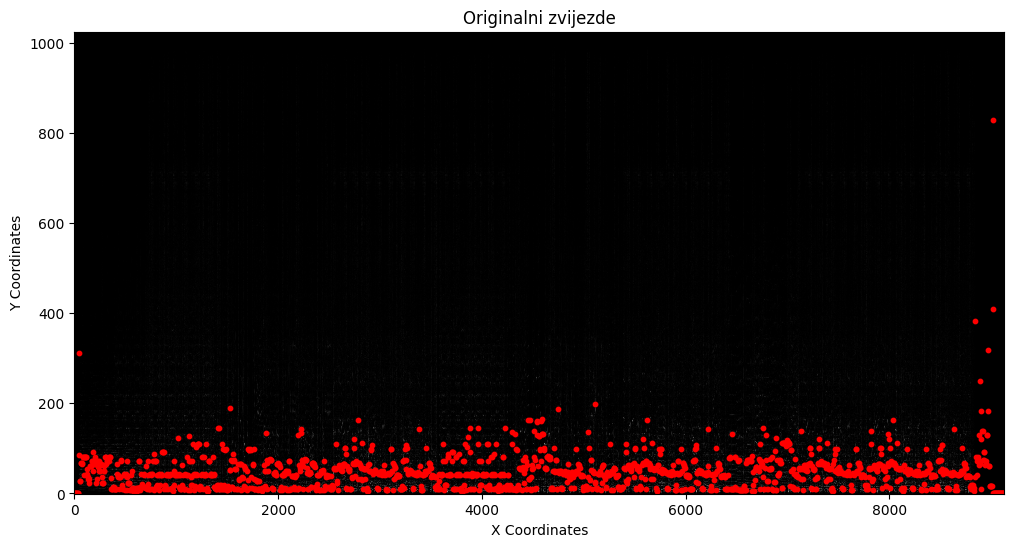

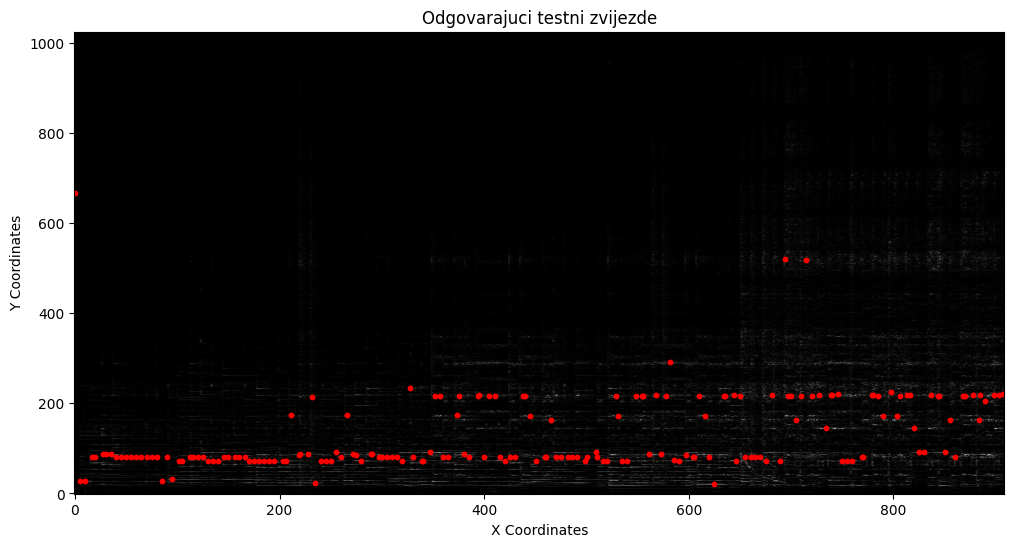

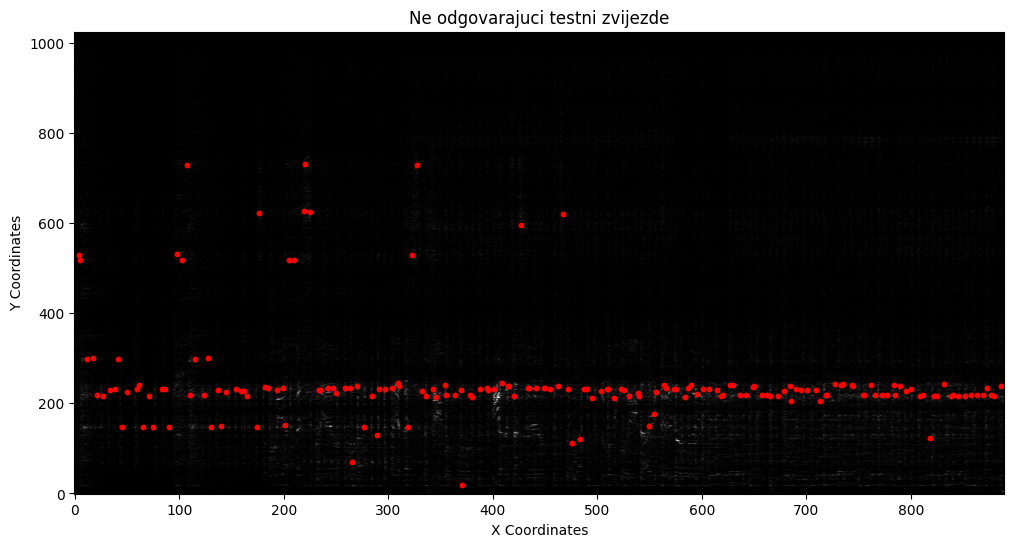

[(45, 31), (40, 25), (6575, 24)]


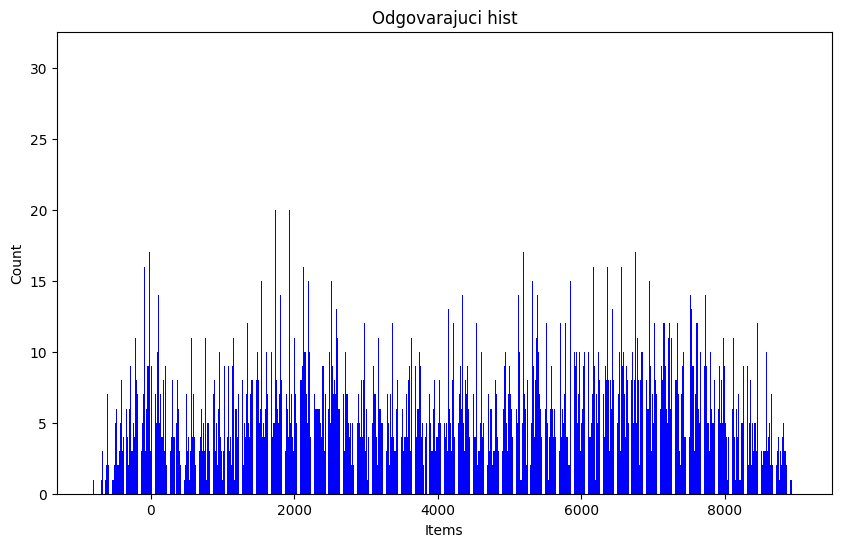

[(865, 3), (1370, 3), (1285, 3)]


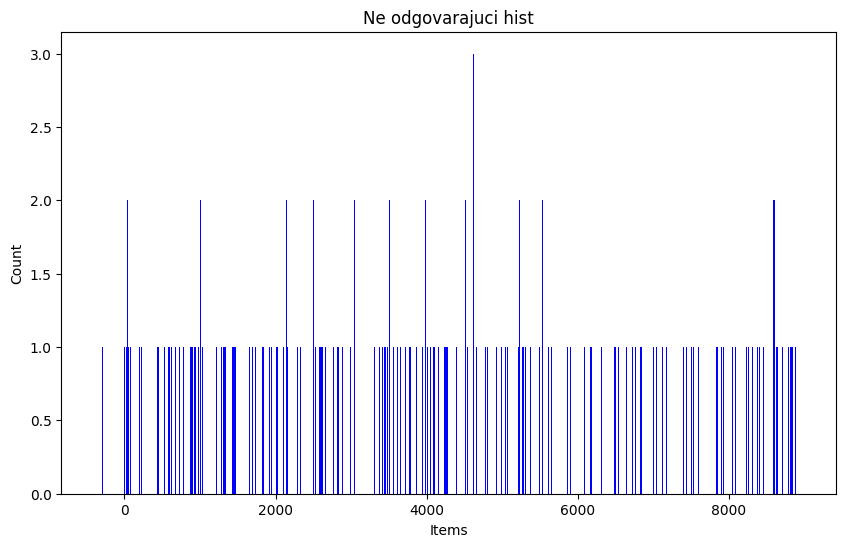

In [127]:
test_fingerprinting(original, positive_test, negative_test, find_maxims, [5])

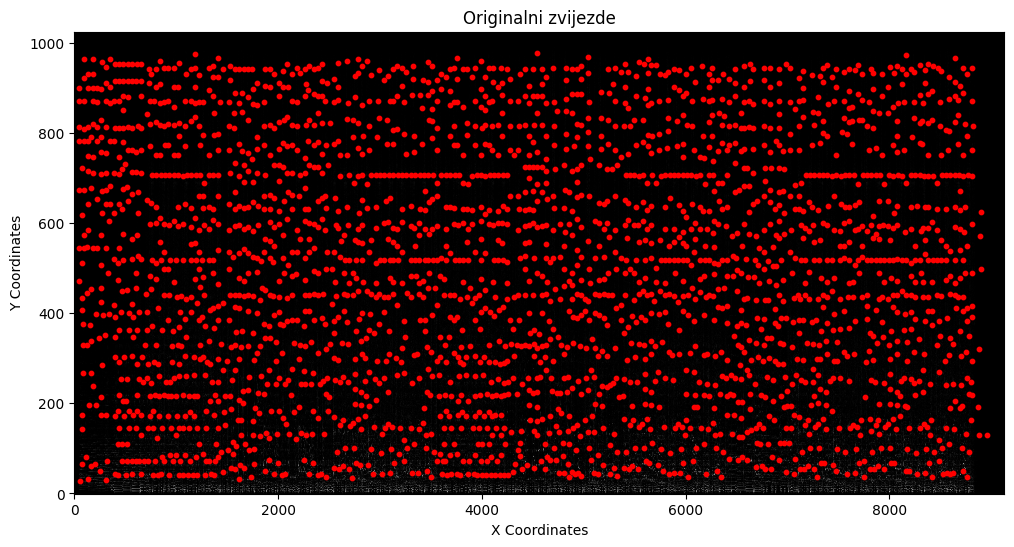

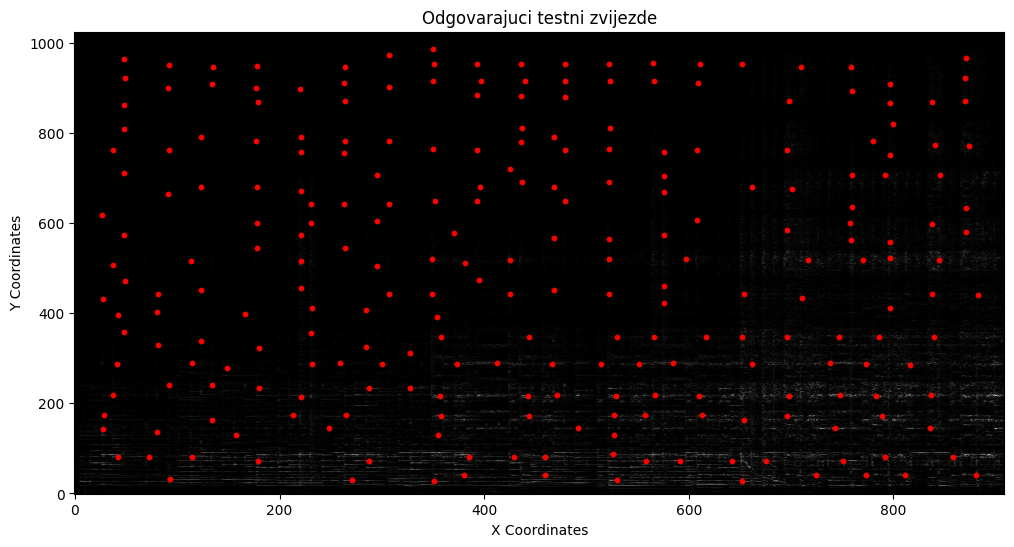

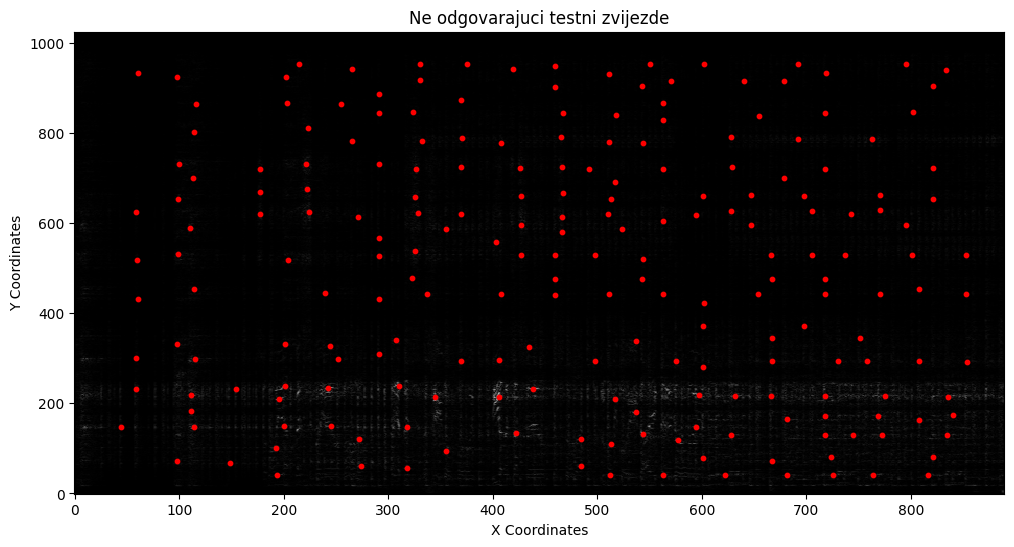

[(44, 90), (43, 50), (216, 37)]


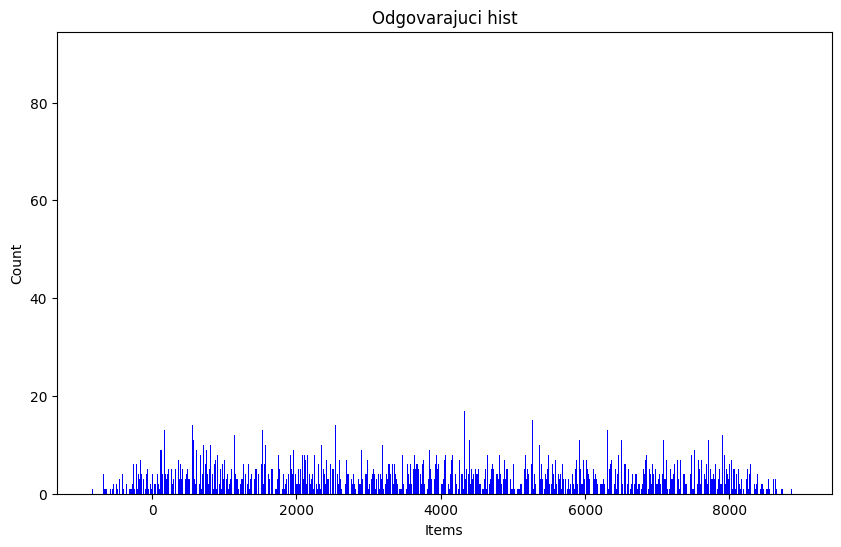

[(7272, 14), (1673, 14), (3637, 13)]


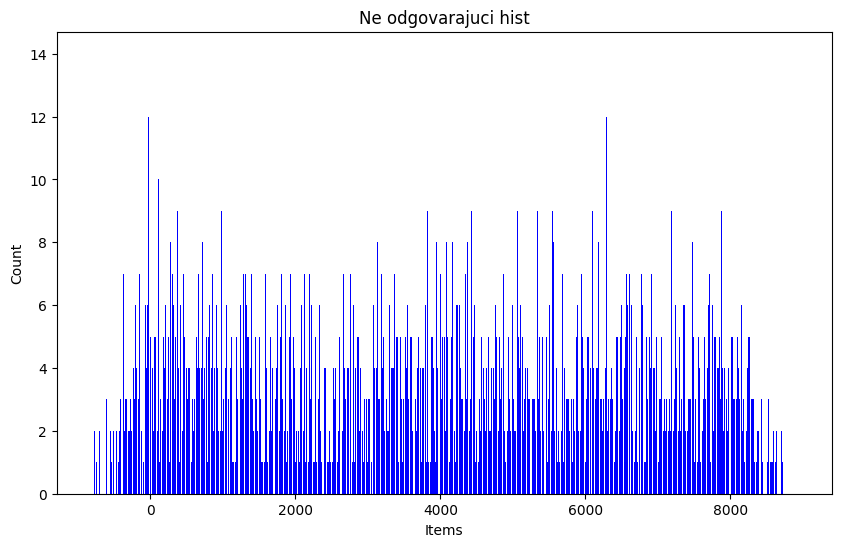

In [128]:
test_fingerprinting(original, positive_test, negative_test, find_local_maxima, [51])

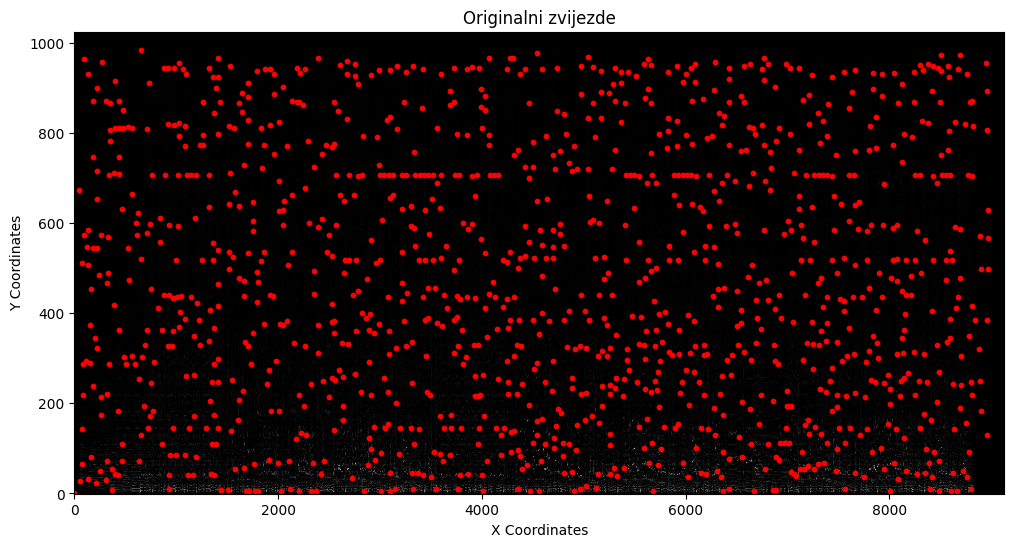

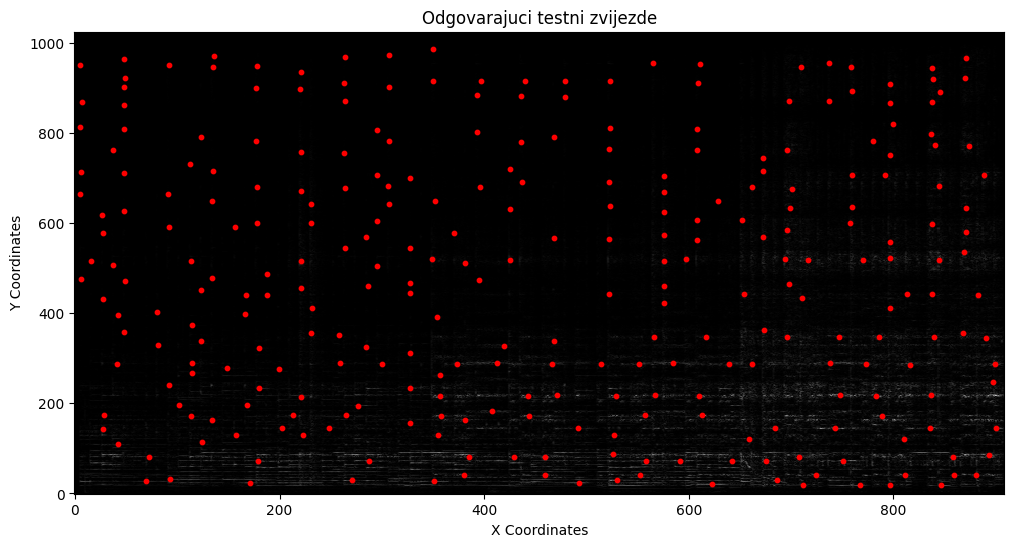

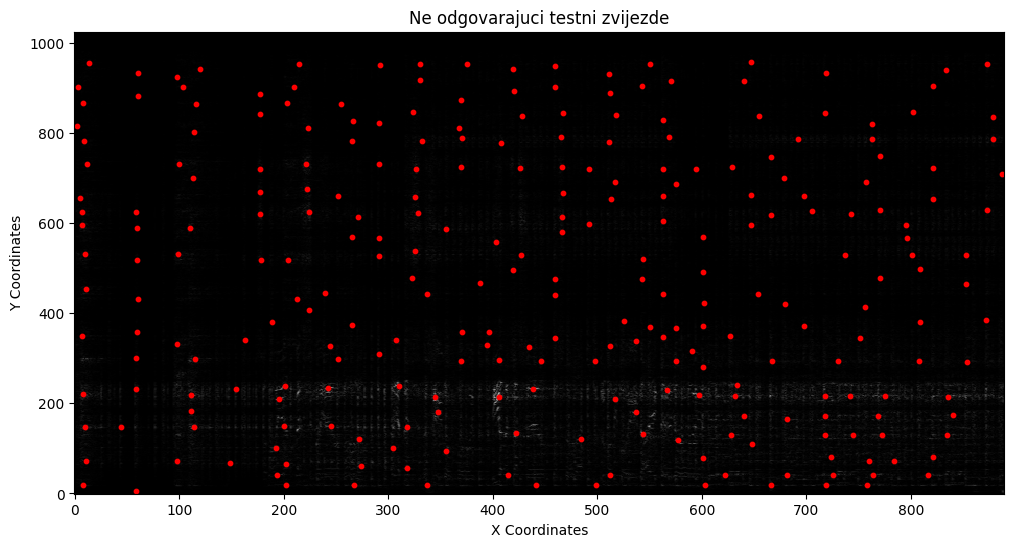

[(43, 21), (44, 18), (-43, 13)]


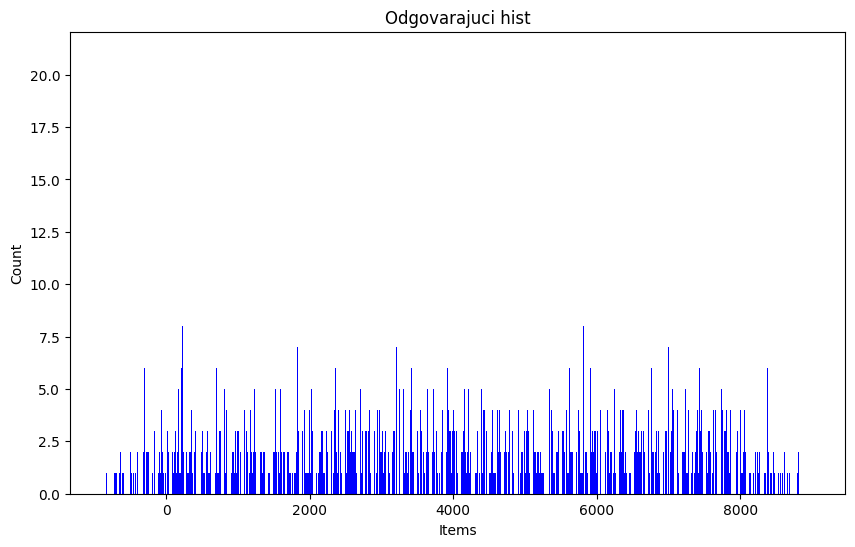

[(6480, 9), (6336, 8), (4099, 8)]


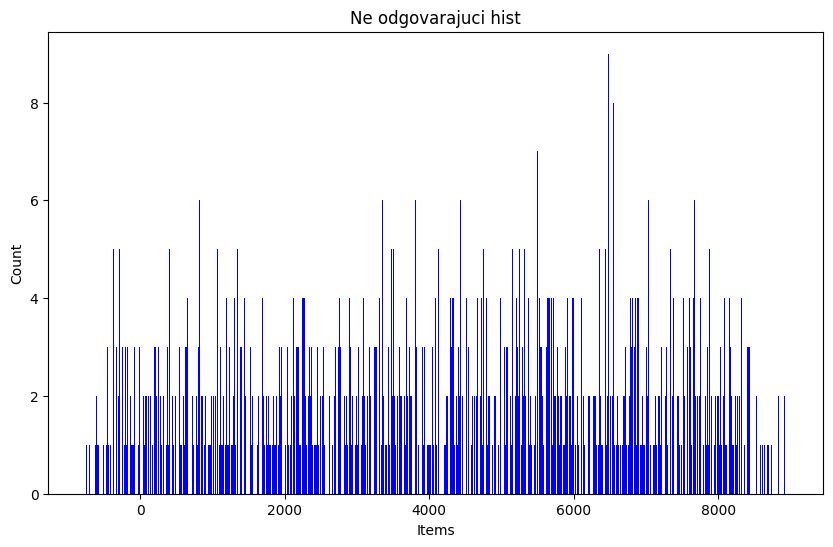

In [131]:
test_fingerprinting(original, positive_test, negative_test, find_local_maxima_heuristic, [2000, 100, 20])

In [ ]:
file = "local_fingerprint.json"
data = json.load("hello.json")

In [ ]:
def predict(S, f, args):
    print(f"Running prediction")
    y_cords, x_cords = f(S, *args)
    most_similar = 0
    best_song = ""
    for song, values in data.items():
        similarity = evaluate_similarity(values['x'], values['y'], x_cords, y_cords, args.tolerance_y, args.tolerance_x)
        print(song, similarity)
        if(similarity > most_similar):
            best_song = song
            most_similar = similarity
    return best_song

def record_audio(duration=10, sample_rate=44100, chunk=1024):
    format = pyaudio.paInt16 
    channels = 1
    p = pyaudio.PyAudio()
    stream = p.open(format=format,
                    channels=channels,
                    rate=sample_rate,
                    input=True,
                    frames_per_buffer=chunk)

    print("Recording started")

    def record_and_predict():
        while True:
            frames = []
            for _ in range(0, int(sample_rate / chunk * duration)):
                data = stream.read(chunk)
                frames.append(np.frombuffer(data, dtype=np.int16))

            audio_data = np.hstack(frames)
            S = librosa.stft(audio_data.astype(np.float32))
            S = np.abs(S)
            prediction = predict(S, find_local_maxima, [51])
            print(f"Prediction: {prediction}")

    thread = threading.Thread(target=record_and_predict)
    thread.daemon = True
    thread.start()
    try:
        while True:
            time.sleep(1)
    except KeyboardInterrupt:
        print("Recording stopped")

    # Stop and close the stream
    stream.stop_stream()
    stream.close()

    # Terminate the PyAudio object
    p.terminate()

# Example usage
record_audio()